In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from africanus.coordinates import radec_to_lm
from pointing import get_pointing_error

In [2]:
beam_2_0_data = np.loadtxt(
    '/fastpool/yuping/jonas-beams/Jonas_f=2.00.csv', delimiter=',',
    skiprows=1, dtype={'names': ('phi', 'theta', 'Xamp', 'Xph', 'Yamp', 'Yph'),
                       'formats': ['f'] * 6})
beam_2_0 = beam_2_0_data['Xamp'] * np.exp(beam_2_0_data['Xph'] * 1j * np.pi/180)

from scipy.interpolate import griddata, interp2d
l, m = np.mgrid[-0.09:0.09:1001j, -0.09:0.09:1001j]
ldata = np.sin(beam_2_0_data['theta'] * np.pi / 180) * np.cos(beam_2_0_data['phi'] * np.pi / 180)
mdata = np.sin(beam_2_0_data['theta'] * np.pi / 180) * np.sin(beam_2_0_data['phi'] * np.pi / 180)

beam_interp = griddata((ldata, mdata), beam_2_0, (l, m))


In [45]:
sep_deg, pa_deg = get_pointing_error(1/60, 2048)
pcenter = SkyCoord(ra = 0. * u.deg, dec=37.129833 * u.deg)
target = pcenter.directional_offset_by(0 * u.deg, 4 * u.deg)
pointings = target.directional_offset_by(pa_deg * u.deg, sep_deg * u.deg)
lms = radec_to_lm(np.array([pointings.ra.to(u.radian).value, pointings.dec.to(u.radian).value]).T,
                  phase_centre=np.array([pcenter.ra.to(u.radian).value, pcenter.dec.to(u.radian).value]))

In [46]:
lms_nominal = radec_to_lm(np.array([[target.ra.to(u.radian).value, target.dec.to(u.radian).value]]),
                  phase_centre=np.array([pcenter.ra.to(u.radian).value, pcenter.dec.to(u.radian).value]))

In [34]:
lms_nominal

array([[0.        , 0.06279052]])

In [35]:
l[:,0]

array([-0.09   , -0.08982, -0.08964, ...,  0.08964,  0.08982,  0.09   ])

In [36]:
m[0]

array([-0.09   , -0.08982, -0.08964, ...,  0.08964,  0.08982,  0.09   ])

In [8]:
from scipy.interpolate import RegularGridInterpolator
# beams_2ghz = RectBivariateSpline(m[0], m[0], beam_interp.real)(res[:,0], res[:,1], grid=False)
f = RegularGridInterpolator((l[:,0], m[0]), beam_interp)

In [58]:
beams_2ghz = f(lms)

Text(0.5, 1.0, 'Amplitude')

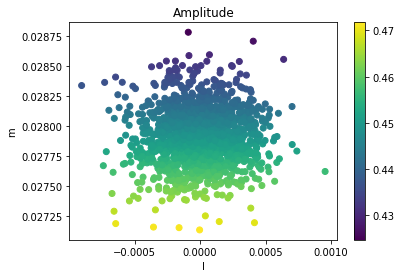

In [59]:
plt.scatter(lms[:,0], lms[:,1], c=np.abs(beams_2ghz))
plt.colorbar()
plt.xlabel('l')
plt.ylabel('m')
plt.title('Amplitude')

Text(0.5, 1.0, 'Amplitude')

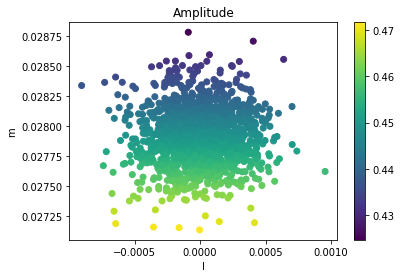

In [60]:
plt.scatter(lms[:,0], lms[:,1], c=beams_2ghz.real)
plt.colorbar()
plt.xlabel('l')
plt.ylabel('m')
plt.title('Amplitude')

In [67]:
ldata.max()

0.087155744

In [61]:
beams_2ghz.shape

(2048,)

In [47]:
freq = 0.7e9
f(lms_nominal * freq/2e9).shape

(1,)

In [48]:
all_gains = np.ones((2048, 8000, 2, 2), dtype=np.complex128)
beam = np.ones((2048, 8000, 2, 2), dtype=np.complex128)
for chan in range(8000):
    freq = (chan * 162.5e3) + 0.7e9
    all_gains[:, chan, :, :] = (f(lms * freq/2e9)/f(lms_nominal * freq/2e9))[:,None, None] * np.identity(2)
    beam[:, chan, :, :] = (f(lms * freq/2e9))[:,None, None] * np.identity(2)

In [49]:
np.any(np.isnan(all_gains))

False

In [50]:
all_gains = all_gains[None, :]

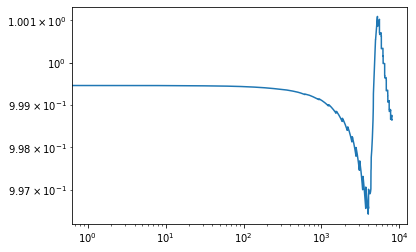

In [52]:
plt.plot(np.abs(all_gains[0,0,:,0,0])**2)
plt.yscale('log')
plt.xscale('log')

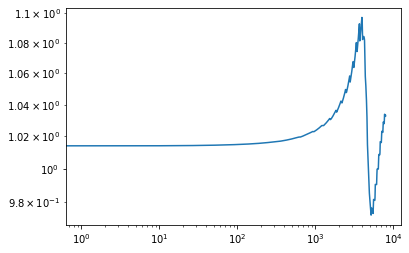

In [53]:
plt.plot(np.abs(all_gains[0,71,:,0,0])**2)
plt.yscale('log')
plt.xscale('log')

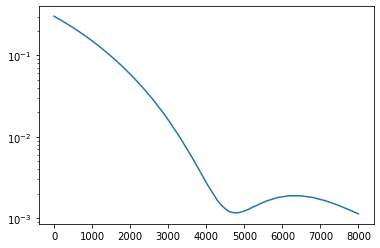

In [54]:
plt.plot(np.abs(beam[0,:,0,0])**2)
plt.yscale('log')
#plt.xscale('log')

In [65]:
(np.abs(all_gains[0,0,:,0,0])**2)[3999]

0.49939766989875745

In [55]:
(np.abs(all_gains[0,0,:,0,0])**2).min()

0.9964211357910748

In [56]:
(np.abs(all_gains[0,0,:,0,0])**2).max()

1.0010926564859373

In [57]:
import dftsource
dftsource.point_src_with_gain(all_gains, '/fastpool/data/W-snapshot-8000chan.ms')

[########################################] | 100% Completed | 17min 54.5s
